# 07. モデルでテストデータの予想をする

【このノートで実施すること】</br>
　学習したモデルでテストデータの予想をしてみます。</br>
　また、hjcデータを参照して、実際に売買していたらどれくらい利益が出るのかを確認してみます。<br>
</br>
【入力】</br>
　・data/06_test_data_and_learned_model/best_lightgbm_model.plk</br>
　・data/06_test_data_and_learned_model/X_test.pkl</br>
　・data/06_test_data_and_learned_model/y_test.pkl</br>
</br>
【出力】</br>
　　なし</br>
</br>

## 07.1 準備

必要なモジュールをインポートしたり、テストデータと学習済みモデルを読み込んだりしています。

In [1]:
import pickle
import joblib
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# インストールしてない場合はコメントアウトしてください
import japanize_matplotlib

In [2]:
# テストデータを読み込む
with open('data/06_test_data_and_learned_model/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)
    
with open('data/06_test_data_and_learned_model/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [3]:
# モデルを読み込む
loaded_model = joblib.load('data/06_test_data_and_learned_model/best_lightgbm_model.pkl')

## 07.2 テストデータの予想をしてみる

学習済みモデルでテストデータの予想を行い、精度（どれくらい予測が的中するのか）を確認してみます。

In [4]:
# テストデータでモデルを評価する

# 学習に使わないカラム
drop_col = "KYI_レースキー"
X_test_dropped = X_test.drop(drop_col, axis=1)

y_pred = loaded_model.predict(X_test_dropped)

print("テストデータの精度:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

テストデータの精度: 0.8103841326491407
              precision    recall  f1-score   support

           0       0.83      0.95      0.89    182131
           1       0.65      0.33      0.44     52111

    accuracy                           0.81    234242
   macro avg       0.74      0.64      0.66    234242
weighted avg       0.79      0.81      0.79    234242



## 07.3 馬券を買っていた場合の利益を調べる

hjcデータを利用して、実際に馬券を購入していたらどれくらいの利益になるのか計算してみます。<br>
機械学習モデルが3着以内に入ると予想した馬に対して、複勝100円を毎回購入するものとします。<br>

In [5]:
# hjcデータを読み込む
with open('data/03_preprocessed_data/df_hjc.pkl', 'rb') as file:
    df_hjc = pickle.load(file)

In [6]:
# X_testとdf_hjcを"レースキー"を使って結合
# ここで"KYI_レースキー"が必要だったため、ノートブック05で生成する”columns_info.json”ファイルの"usage"属性に”key”という値を設けています。
df_kyi_hjc = pd.merge(X_test, df_hjc, left_on='KYI_レースキー', right_on='レースキー', how='left')

In [7]:
# モデルの予想した結果をpd.dataframe形式に変換
y_pred_df = pd.DataFrame(y_pred, columns=['複勝_予想'])

# テストデータの 説明変数、目的変数、モデルの予想した結果 を結合
result_df = pd.concat([df_kyi_hjc.reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [8]:
# 馬券が的中したか調べ、払戻金から利益を計算します
def calculate_betting_profit(df):
    # "的中"カラムを作成
    df['的中'] = np.where(df['複勝_予想'] == df['3着以内'], 1, 0)

    # "利益"カラムを計算
    def calculate_profit(row):
        if row['複勝_予想'] == 0: # 馬券を買ってないとき
            return 0       
        elif row['的中'] == 0: # 馬券を買って、外れたとき 
            return -100
        else: # 馬券を買って、的中したとき
            if row['KYI_馬番'] == row['複勝払戻1_馬番']:
                return row['複勝払戻1_払戻金'] - 100
            elif row['KYI_馬番'] == row['複勝払戻2_馬番']:
                return row['複勝払戻2_払戻金'] - 100
            elif row['KYI_馬番'] == row['複勝払戻3_馬番']:
                return row['複勝払戻3_払戻金'] - 100
            else:
                return None  # 一致する馬番がない場合

    # "利益"カラムをDataFrameに適用
    df['利益'] = df.apply(calculate_profit, axis=1)

    return df

In [9]:
# メソッドを使用して新しいカラムを計算
result_df = calculate_betting_profit(result_df)

In [ ]:
#　新しく生成されたカラムの確認
# 「的中」カラムと「利益」カラムが生成されているはずです。
result_df.head()

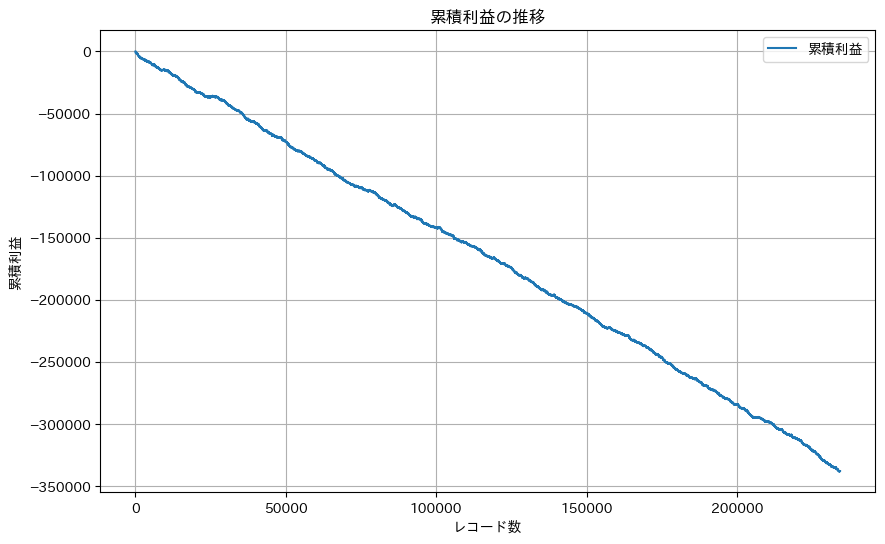

In [11]:
# 利益カラムのリスト
profit_columns = ['利益']

# 線グラフを描画
plt.figure(figsize=(10,6))

for profit_col in profit_columns:
    # "利益"カラムの累積和を計算
    result_df['累積' + profit_col] = result_df[profit_col].cumsum()

    # 累積利益の線グラフをプロット
    plt.plot(result_df['累積' + profit_col], label='累積' + profit_col)

# グラフのタイトルと軸ラベルを設定
plt.title('累積利益の推移')
plt.xlabel('レコード数')
plt.ylabel('累積利益')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

結果、<strong>すごいマイナス</strong>になってしまいました笑<br>
モデルの精度は80％を超えているので、そこそこ的中はするのですが、オッズが低く、当たったとしても100円が130円になって30円しか利益が出ない、ということがザラでした。<br>
一方、馬券を外してしまうとマイナス100円なので、一発外した時のマイナスが大きく、的中した馬券でそれを取り返すことができていないようです。<br>
<br>
モデルにはまだまだ改良の余地がありそうなので、色々試してみたいなと思いました。<br>
<br>
<strong>試してみたいこと</strong><br>
・騎手や調教師の情報も使って学習してみる<br>
・LightGBM以外のモデルを使ってみる<br>
・特定のレース場のみ、芝コースのみ、など条件を絞って学習してみる<br>
<br>
<br>
謝辞：ここまで読んでくださってありがとうございました！<br>